In [1]:
# imports
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# define algorithms

# exact simulation algorithm
def exact_sim(theta, dt=0.01):
    D = 4.0
    Ke, Ka, Cl, sigma = theta
    alpha = (D*Ka*Ke) / Cl

    times = np.array([0, 0.25, 0.5, 1, 2, 3.5, 5, 7, 9, 12])
    N = len(times)
    sim_data = np.zeros(N)

    for i in range(N-1):
        dt_i = times[i+1] - times[i]
        X_i = sim_data[i]

        # Deterministic Term
        first_det_term = np.exp(-Ke * dt_i) * X_i
        second_det_term = alpha/(Ke - Ka) * (np.exp(-Ka * times[i+1]) - np.exp(-Ke * dt_i)*np.exp(-Ka * times[i]))
        det_term = first_det_term + second_det_term

        # Stochastic Noise
        var = sigma**2/(2*Ke) * (1 - np.exp(-2*Ke*dt_i))
        std = np.sqrt(var)
        noise = np.random.normal(0,std)

        X_next = det_term + noise
        sim_data[i+1] = X_next

    return np.array(sim_data[1:])

# algorithm 1: simple ABC rejection
def algorithm1(N, prior, model, M, discrep, data, eps):
    """
    Simple ABC Algorithm
    """
    theta = []
    n_attempts = 0

    # Keep proposing from the prior until we have N accepted samples
    while len(theta) < N:
        # Propose a parameter from the prior
        theta_star = prior()

        # Simulate dataset
        gen_data = model(theta_star, M)

        # Compute discrepancy between simulated and observed data
        diff = discrep(gen_data, data)
        n_attempts += 1

        # Accept the sample if it is within the tollerance
        if diff < eps:
            theta.append(theta_star)
    return np.asarray(theta), n_attempts

# algorithm 2: ABC-MCMC

def algorithm2(check_ESS, var, q_proposal, pi_density, model, M, calculate_ESS, discrep, data, eps, max_iter):
    theta = [0.0]
    accepted = 0
    current_ESS = 0.0
    target_ESS = 500.0
    n_iter = 0

    while current_ESS < target_ESS:
        for _ in range(check_ESS):
            theta_curr = theta[-1]
            theta_star = q_proposal(theta_curr, var)
            gen_data = model(theta_star, M)
            diff = discrep(gen_data, data)

            alpha = pi_density(theta_star) / pi_density(theta_curr)

            if (diff < eps) and (np.random.uniform(0, 1) < alpha):
                theta.append(theta_star)
                accepted += 1
            else:
                theta.append(theta_curr)

            n_iter += 1
            if n_iter > max_iter:
                print(f"[Warning]: Iteration limit reached. Using N_eff = {current_ESS}")
                return np.asarray(theta), accepted

        current_ESS = calculate_ESS(np.array(theta))

    return np.asarray(theta), accepted

# Euler-Maruyama discretization scheme
def euler_maruyama(theta, dt):
    D = 4.0
    Ke, Ka, Cl, sigma = theta
    alpha = (D*Ka*Ke) / Cl

    times = np.array([0, 0.25, 0.5, 1, 2, 3.5, 5, 7, 9, 12])
    T = times[-1]
    N = int(np.ceil(T/dt))
    xs = np.zeros(N+1)
    ts = np.linspace(0.0, N*dt, N+1)

    for i in range(N):
        prev_x = xs[i]
        prev_t = ts[i]

        # Deterministic Term
        exp_term = np.exp(-Ka * prev_t)
        b_val = alpha * exp_term - (Ke * prev_x)
        det_term = b_val * dt

        # Stochastic Noise
        dW = np.random.normal(0,np.sqrt(dt))
        noise = sigma * dW

        new_x = prev_x + det_term + noise
        xs[i+1] = new_x

    idx = np.round(times / dt).astype(int)
    return xs[idx][1:]

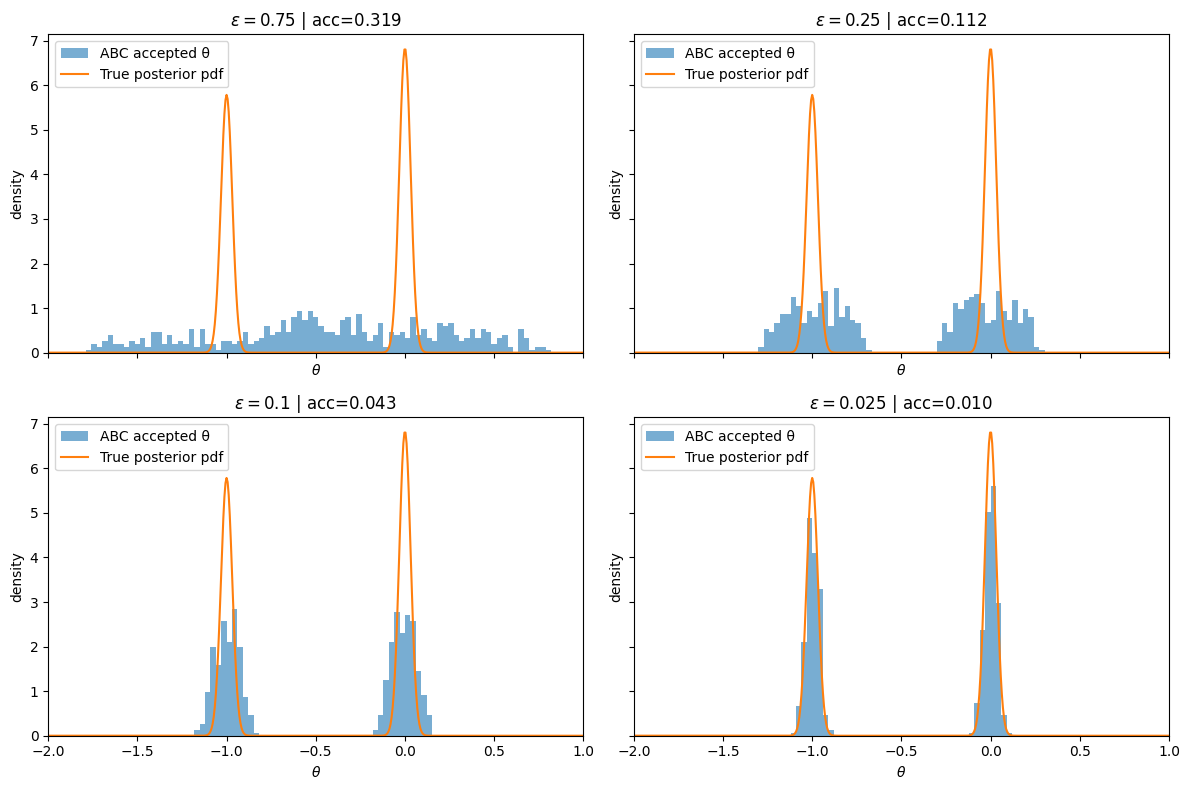

In [3]:
# Goal 1: Algorithm 1 tested on Guassian mixture posterior distribution

def abs_diff_discrepancy(gen_data, data):
    """
    Absolute difference discrepancy metric
    """
    # Calculating the mean of the two datasets
    mean_gen_data = np.mean(gen_data)
    mean_data = np.mean(data)
    # Returning the absolute difference between the means
    return np.abs(mean_gen_data - mean_data)

def prior_goal1():
    """
    Prior distribution goal 1
    """
    # Simulating the prior with the parameters given for goal 1
    mu = 0
    var = 3
    return np.random.normal(mu,np.sqrt(var))

def model_goal1(theta, M):
    """
    Model for simulating data for goal 1.
    """
    # Generate a dataset of size M from the model givne in exercise 1
    a = 1
    var = 0.1
    # Probability 1/2 to be drawn from each of the distributions
    distr = np.random.randint(0,2)
    if distr == 0:
        return np.random.normal(theta, np.sqrt(var), M)
    else: 
        return np.random.normal(theta + a, np.sqrt(var), M)

def true_posterior_goal1(theta):
    """
    True closed form posterior for goal 1. 
    """
    # Clsoed form posterior as given in the exercise description
    a = 1
    M = 100
    var_1 = 0.1
    var = 3
    data_mean = 0

    alpha = 1 / (1 + np.exp(a * (data_mean - (a / 2)) * (M / (M * var + var_1))))
    mu_1 = (var / (var + var_1 / M)) * data_mean 
    mu_2 = (var / (var + var_1 / M)) * (data_mean - a)
    var_post = var_1 / (M + (var_1 / var))
    std = np.sqrt(var_post)

    return alpha * norm.pdf(theta, loc = mu_1, scale = std) + (1 - alpha) * norm.pdf(theta, loc = mu_2, scale = std)

    

def goal1():
    """
    Code for creating the plots for experiment 1
    """

    # Setting seed for reproducibility
    np.random.seed(42)

    
    M = 100
    eps = [0.75, 0.25, 0.1, 0.025]
    data = np.zeros(M) # Observed data
    N = 500

    # True posterior curve for plots
    grid = np.linspace(-3, 3, 1000)
    true_pdf = true_posterior_goal1(grid)

    # define fixed bins
    bin_edges = np.linspace(-2, 1, 100)

    # 2x2 plot, one panel per tolerance
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
    axes = axes.ravel()

    for ax, e in zip(axes, eps):
        # Run ABC rejection
        thetas, num_props = algorithm1(
            N, prior_goal1, model_goal1, M, abs_diff_discrepancy, data, e
        )
        acc = N / num_props

        # Plot accepted histogram and overlay true pdf
        ax.hist(thetas, bins=bin_edges, density=True, alpha=0.6, label="ABC accepted θ")
        ax.plot(grid, true_pdf, label="True posterior pdf")
        ax.set_title(rf"$\epsilon={e}$ | acc={acc:.3f}")
        ax.set_xlim([-2, 1])
        ax.set_xlabel(r"$\theta$")
        ax.set_ylabel("density")
        ax.legend()

    plt.tight_layout()
    plt.show()

# run goal1
goal1()

Plot 1: ε=0.75
Plot 2: ε=0.25
Plot 3: ε=0.1
Plot 4: ε=0.025


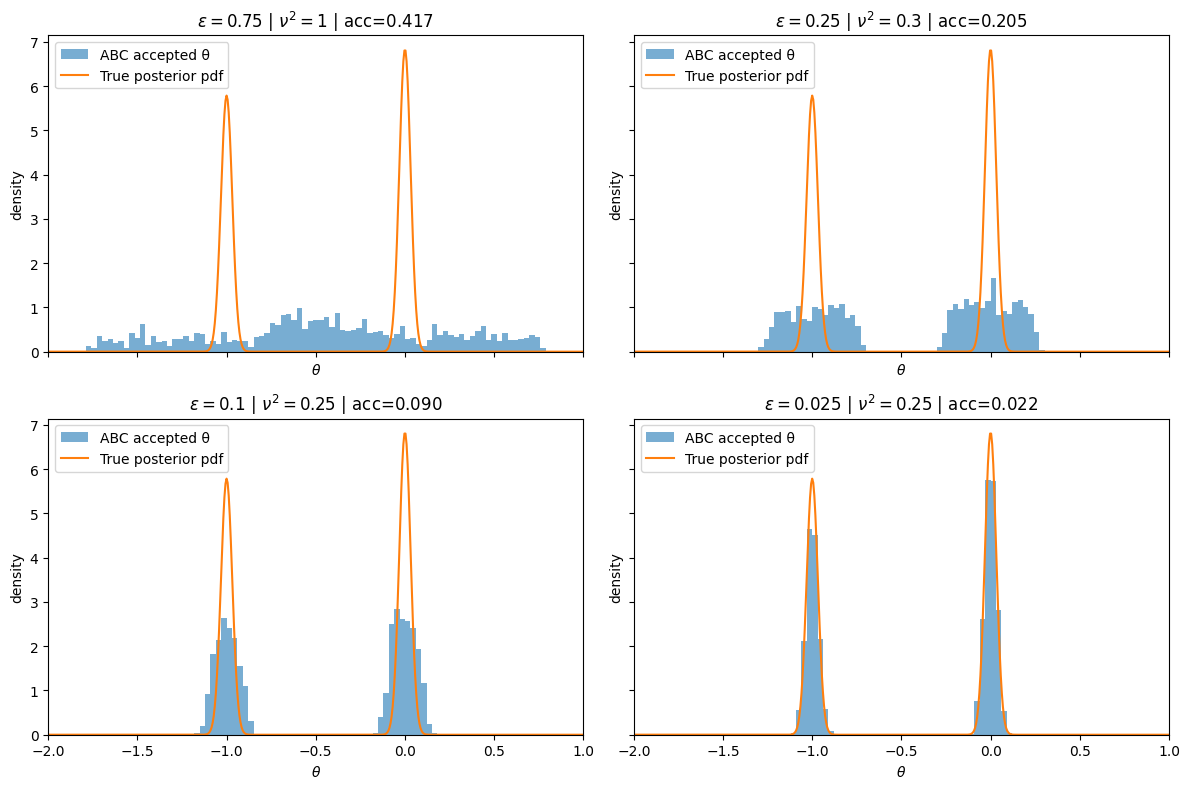

In [4]:
# Goal 3: Algorithm 2 tested on Guassian mixture posterior distribution

def q_proposal(theta,variance):
    """
    Proposal random walk function for the next parameter theta* given the current theta.

    Inputs:
        theta (int): Value of parameter theta in the current iteration.
        variance (int): Variance of the proposal random walk (hyperparameter to be 'tuned').
    """
    return np.random.normal(theta, np.sqrt(variance)) # Since the function takes the std, not variance.

def pi_density(theta):
    """
    ...
    """
    return norm.pdf(theta, 0, np.sqrt(3))


def calculate_ESS(chain, M=100):
    """
    Calculate the Effective Sample Size of a given chain.
    """
    N = len(chain)

    # Determine block size T
    T = N // M

    # Ensure the chain length is a multiple of M for precise reshaping
    if N % M != 0:
        N = M * T
        chain = chain[-N:]

    # Reshape into matrix MxT --> each row represents a batch
    blocks = chain.reshape(M, T)
    # Compute the mean over batches
    mu_i = np.mean(blocks, axis=1)

    # Estimate sigma_MCMC^2 = T * Sample_Var(batch_means)
    sigma2_mu1 = np.var(mu_i, ddof=1) # ddof=1 --> denominator is 1/(M-1) (as the slides!)
    sigma2_MCMC = T * sigma2_mu1

    # Calculate c(0) --> variance of the chain
    c0 = np.var(chain, ddof=1)

    # Final check --> 0 variance (in the weird case all bath means were the same)
    if sigma2_MCMC == 0:
        return 0

    # Final ESS calculation: ESS = N * (c0 / sigma2_MCMC)
    ESS = N * (c0 / sigma2_MCMC)

    return ESS


def goal3():

    # Setting seed for reproducibility
    np.random.seed(42)

    check_ESS = 2000  # Check the ESS of the current chain every 500 iterations.
    max_iter = 200000
    M = 100
    data = [0.0]

    eps = [0.75, 0.25, 0.1, 0.025]
    var = [1, 0.3, 0.25, 0.25]

    grid = np.linspace(-3, 3, 1000)
    true_pdf = true_posterior_goal1(grid)
    bin_edges = np.linspace(-2, 1, 100)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

    for idx, e in enumerate(eps):
        print(f"Plot {idx+1}: ε={e}")
        v = var[idx]
        thetas, accepted = algorithm2(
            check_ESS, v, q_proposal, pi_density, model_goal1, M, calculate_ESS, abs_diff_discrepancy, data, e, max_iter
        )
        acc_rate = accepted / len(thetas)

        ax = axes[idx//2, idx%2]
        ax.hist(thetas, bins=bin_edges, density=True, alpha=0.6, label="ABC accepted θ")
        ax.plot(grid, true_pdf, label="True posterior pdf")
        ax.set_title(rf"$\epsilon={e}$ | $\nu^2={v}$ | acc={acc_rate:.3f}")
        ax.set_xlim([-2, 1])
        ax.set_xlabel(r"$\theta$")
        ax.set_ylabel("density")
        ax.legend()

    plt.tight_layout()
    # plt.savefig(f"ResultsAlgo2.png")
    plt.show()

# run goal3()
goal3()

In [5]:
# Goal 4: Data Generation

def sample_theta_goal4():
    log_Ke = np.random.normal(-2.7, 0.6)
    log_Ka = np.random.normal(0.14, 0.4)
    log_Cl = np.random.normal(-3,0.8)
    log_sig = np.random.normal(-1.1, 0.3)
    return np.array([np.exp(log_Ke),np.exp(log_Ka),np.exp(log_Cl), np.exp(log_sig)])

def simulate_dataset(theta, method='exact', dt=0.01):
    if method == 'exact':
        return exact_sim(theta=theta)

    elif method == 'em':
        return euler_maruyama(theta=theta, dt=dt)

    else:
        raise ValueError("Method Not Supported: must be either 'exact' or 'em' (Euler-Maruyama).")

def create_dataset(n, method='exact', dt=0.01):
    X = np.zeros((n,10))
    Y = np.zeros((n,4))

    for i in range(n):
        theta_i = sample_theta_goal4()
        D_i = simulate_dataset(theta=theta_i, method=method, dt=dt)
        X[i,0] = 1.0
        X[i, 1:] = D_i
        Y[i,:] = theta_i
    
    return X, Y

def get_betas(X, Y):
    betas, *_ = np.linalg.lstsq(X,Y)
    return betas

def summary_stat(data, betas):
    x = np.zeros(10)
    x[0] = 1.0
    x[1:] = data
    return x @ betas
    
def goal4():

    # Setting seed for reproducibility
    np.random.seed(42)

    # Generate true data
    given_theta = np.array([0.08,1.5,0.04,0.2])
    data_obs = simulate_dataset(theta=given_theta, method='exact')

    print("Observed Ground-Truth Data:")
    print(data_obs.tolist())

    # Generate sample parameters from prior: Y, and corresponding data: X
    X, Y = create_dataset(n=10000, method='exact')

    # Estimated regression coefficients
    betas = get_betas(X,Y)
    print("\nEstimated Regression Coefficients:")
    print(betas)

    # Verification: check if the estimated coeffs. recover the ground-truth parameters with the summarised statistics
    S_D = summary_stat(data_obs, betas)
    print("\nValidation:")
    print(f"True Params: {given_theta.tolist()}")
    print(f"Est. Params: {np.round(S_D, 4).tolist()}")

# run goal4()
goal4()

Observed Ground-Truth Data:
[2.5244694735854996, 4.162033048728708, 6.0383337613830905, 7.186801738908871, 6.648854957168407, 5.877585545313985, 5.4255053174403285, 4.824299625242119, 3.6500043027923863]

Estimated Regression Coefficients:
[[ 7.44561862e-02  1.24710034e+00  1.01127723e-01  3.49306437e-01]
 [ 1.58830972e-04  2.62007309e-01 -2.37623672e-03 -5.54700001e-03]
 [-3.28256980e-03  1.02249054e-01  4.72997767e-04  6.01463759e-03]
 [ 1.74014720e-03 -8.54784918e-02 -9.05970914e-05 -3.54261057e-03]
 [ 7.22512844e-03 -6.94400493e-02  1.08778212e-03 -4.45820806e-04]
 [ 2.51474228e-03 -2.17069261e-02 -1.52769969e-03  8.02024258e-03]
 [-1.46203496e-04 -7.39464367e-03 -4.68653692e-04 -1.23516932e-02]
 [-3.97129885e-03  1.74855515e-03  1.07809492e-03  5.28656799e-03]
 [-2.38977500e-03  2.06048870e-02 -2.00656523e-03  4.27676144e-03]
 [-8.49609658e-03  1.56580730e-02 -6.59910422e-03 -3.63784208e-03]]

Validation:
True Params: [0.08, 1.5, 0.04, 0.2]
Est. Params: [0.0754, 1.2971, 0.0635, 0.

eps=0.25 acc=0.307
eps=0.7 acc=0.712
eps=1.0 acc=0.784


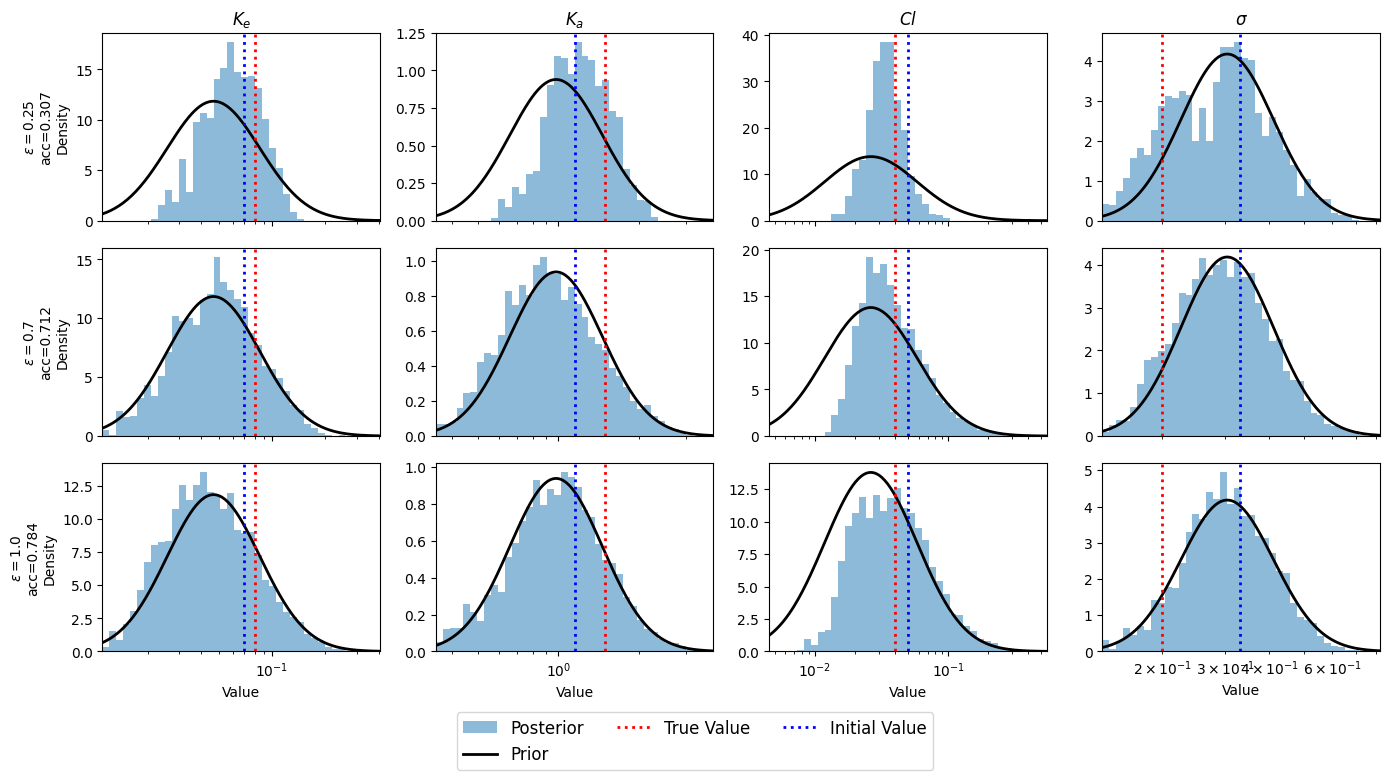

Tolerance    | Ke         | Ka         | Cl         | sigma     
-----------------------------------------------------------------
0.25         | 0.0711     | 1.3169     | 0.0393     | 0.3338    
0.7          | 0.0728     | 1.1976     | 0.0653     | 0.3377    
1.0          | 0.0733     | 1.2604     | 0.0786     | 0.3389    


In [6]:
# Goal 5: ABC-MCMC for parameter estimation from data

def discrep_goal5(s_star, s_obs):
    theta_0 = np.array([0.07,1.15,0.05,0.33])
    s_diff = s_star - s_obs
    return np.sqrt(np.sum((s_diff / theta_0)**2))

def q_proposal_goal5(log_theta_curr, prop_sd):
    rvs = np.random.normal(0,prop_sd,4)
    next_log_thetas = log_theta_curr + rvs
    return next_log_thetas

def pi_density_goal5(log_theta_star):
    Ke, Ka, Cl, sigma = log_theta_star
    log_Ke = norm.logpdf(Ke, -2.7, 0.6)
    log_Ka = norm.logpdf(Ka,0.14, 0.4)
    log_Cl = norm.logpdf(Cl,-3,0.8)
    log_sig = norm.logpdf(sigma, -1.1, 0.3)
    return log_Ke + log_Ka + log_Cl + log_sig

def algorithm2_goal5(N, prop_sd, q_proposal, pi_density, model, S, discrep, obs_data, eps, theta0 = [0.07,1.15,0.05,0.33]):
    theta = [theta0]
    accepted = 0
    sum_obs_data = S(obs_data)

    for i in range(N):
        theta_curr = theta[-1]
        log_theta_curr = np.log(theta_curr)
        log_theta_star = q_proposal(log_theta_curr, prop_sd)
        theta_star = np.exp(log_theta_star)
        gen_data = model(theta_star)
        sum_gen_data = S(gen_data)
        diff = discrep(sum_gen_data, sum_obs_data)

        log_alpha_cond = pi_density(log_theta_star) - pi_density(log_theta_curr)
        alpha = min(0.0, log_alpha_cond)
        if (diff < eps) and (np.log(np.random.uniform()) < alpha):
            theta.append(theta_star)
            accepted += 1
        else:
            theta.append(theta_curr)

    return np.asarray(theta), accepted

def summary_stat_goal5(betas):
    def summary_stat(data):
        x = np.zeros(10)
        x[0] = 1.0
        x[1:] = data
        return x @ betas
    return summary_stat

def goal5():

    # Setting seed for reproducibility
    np.random.seed(42)

    eps_list = [0.25, 0.7, 1.0]
    thetas_eps = {}
    acc_eps = {}
    prop_sd = np.array([0.15, 0.10, 0.20, 0.08])
    given_theta = np.array([0.08,1.5,0.04,0.2])
    data_obs = simulate_dataset(theta=given_theta, method='exact')

    N = 10000
    X, Y = create_dataset(2000, method='exact')
    betas = get_betas(X,Y)
    sum_stat = summary_stat_goal5(betas)
    for e in eps_list:
        thetas, accepted = algorithm2_goal5(
            N, prop_sd, q_proposal_goal5, pi_density_goal5,
            exact_sim, sum_stat, discrep_goal5, data_obs, e
        )
        thetas_eps[e] = thetas
        acc_eps[e] = accepted / N
        print(f"eps={e} acc={acc_eps[e]:.3f}")


    use_log_scale = True

    param_names = [r"$K_e$", r"$K_a$", r"$Cl$", r"$\sigma$"]
    true_params = [0.08, 1.5, 0.04, 0.2]
    theta0 = [0.07, 1.15, 0.05, 0.33]


    prior_params = [(-2.7, 0.6), (0.14, 0.4), (-3.0, 0.8), (-1.1, 0.3)]
    burn = 2000  # adjust or set to 0
    num_bins = 40

    fig, axes = plt.subplots(3, 4, figsize=(14, 8), sharex='col')

    for r, e in enumerate(eps_list):
        samples = thetas_eps[e][burn:]  # shape (N+1-burn, 4)

        for c in range(4):
            ax = axes[r, c]
            data_col = samples[:, c]

            # Prior stats in log-space
            mu_prior, sd_prior = prior_params[c]
            log_low = mu_prior - 3 * sd_prior
            log_high = mu_prior + 3 * sd_prior
            
            # Set ranges to be 3 sd from mean
            x_min, x_max = np.exp(log_low), np.exp(log_high)

            if use_log_scale:
                bins = np.exp(np.linspace(log_low, log_high, num_bins + 1))
                ax.set_xscale('log')
            else:
                bins = np.linspace(x_min, x_max, num_bins + 1)
            
            
            # Plot Posterior Histogram
            ax.hist(data_col, bins=bins, density=True, alpha=0.5, label="Posterior")
            ax.set_xlim(x_min, x_max)

            # --- Plot Prior Density Curve ---
            if use_log_scale:
                x_range = np.exp(np.linspace(log_low, log_high, 200))
            else:
                x_range = np.linspace(x_min, x_max, 200)

            prior_pdf = (np.exp(-(np.log(x_range) - mu_prior)**2 / (2 * sd_prior**2)) / 
                         (x_range * sd_prior * np.sqrt(2 * np.pi)))
            ax.plot(x_range, prior_pdf, 'k-', lw=2, label="Prior")

            # Add red dotted line for the true value
            ax.axvline(true_params[c], color='red', linestyle=':', linewidth=2, label="True Value")
            
            # Add blue dotted line for the initial value (theta0)
            ax.axvline(theta0[c], color='blue', linestyle=':', linewidth=2, label="Initial Value")
            if r == 0:
                ax.set_title(param_names[c])
            if c == 0:
                # Epsilon and Acceptance rate in LaTeX
                ax.set_ylabel(rf"$\epsilon={e}$" + "\n" + rf"acc={acc_eps[e]:.3f}" + "\n" + "Density")
            if r == 2:
                ax.set_xlabel("Value")

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0.02), fontsize=12)


    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()


    print(f"{'Tolerance':<12} | {'Ke':<10} | {'Ka':<10} | {'Cl':<10} | {'sigma':<10}")
    print("-" * 65)

    for eps, samples in thetas_eps.items():
        # Slice the array to remove the first 2000 samples
        clean_samples = samples[burn:]
        
        # Calculate the mean along the columns (axis 0)
        means = clean_samples.mean(axis=0)
        
        print(f"{eps:<12} | {means[0]:<10.4f} | {means[1]:<10.4f} | {means[2]:<10.4f} | {means[3]:<10.4f}")

    # return data to use in goal6
    return thetas_eps, acc_eps, data_obs

# run goal5()
thetas_eps, acc_eps, data_obs = goal5()


In [7]:
import numpy as np

# --- Configuration ---
burn_in = 2000
param_names_tex = [r"$K_e$", r"$K_a$", r"$Cl$", r"$\sigma$"]
initial_vals = [0.07, 1.15, 0.05, 0.33]
true_vals = [0.08, 1.5, 0.04, 0.2]

# Prior hyperparameters (log-space mean and sd)
prior_log_params = [(-2.7, 0.6), (0.14, 0.4), (-3.0, 0.8), (-1.1, 0.3)]

# Calculate Prior Means (Log-Normal Mean = exp(mu + sigma^2 / 2))
prior_means = [np.exp(m + (s**2)/2) for m, s in prior_log_params]

# Get sorted tolerances
sorted_eps = sorted(thetas_eps.keys())

# --- Construct the LaTeX String ---

# 1. Header Construction
# We use a nested header to show Epsilon and its corresponding Acceptance Rate
latex_header = [
    r"\begin{table}[htbp]",
    r"\centering",
    r"\caption{Parameter Estimation Summary. 'Post' columns show the posterior mean and percentage difference from the True value. Acceptance rates (Acc.) are provided for each tolerance level.}",
    r"\label{tab:abc_pivoted_with_acc}",
    r"\resizebox{\textwidth}{!}{%",
    r"\begin{tabular}{lcccc ccc}",
    r"    \toprule",
    r"    & & & & \multicolumn{1}{c}{\textbf{Post}} & \multicolumn{1}{c}{\textbf{Post}} & \multicolumn{1}{c}{\textbf{Post}} \\",
    f"    \\textbf{{Param}} & \\textbf{{Init}} & \\textbf{{Prior}} & \\textbf{{True}} & $\\epsilon={sorted_eps[0]}$ & $\\epsilon={sorted_eps[1]}$ & $\\epsilon={sorted_eps[2]}$ \\\\",
    f"    & & & & (Acc: {acc_eps[sorted_eps[0]]:.3f}) & (Acc: {acc_eps[sorted_eps[1]]:.3f}) & (Acc: {acc_eps[sorted_eps[2]]:.3f}) \\\\",
    r"    \midrule"
]

latex_rows = []

# 2. Row Construction
for i in range(4): # Loop through Ke, Ka, Cl, sigma
    p_name = param_names_tex[i]
    init = initial_vals[i]
    prio = prior_means[i]
    tru  = true_vals[i]
    
    # Start the row with constant values
    current_row = f"    {p_name:<10} & {init:<6.3f} & {prio:<6.3f} & {tru:<6.3f} "
    
    # Append a column for each epsilon
    for e in sorted_eps:
        post = thetas_eps[e][burn_in:, i].mean()
        p_diff = ((post - tru) / tru) * 100
        
        # Format the mean and % difference cell
        # Triple braces {{{ }}} escape LaTeX braces in Python f-strings
        current_row += f"& \\textbf{{{post:<6.3f}}} ({p_diff:>+4.1f}\\%) "
        
    current_row += r"\\"
    latex_rows.append(current_row)

# 3. Footer Construction
latex_footer = [
    r"    \bottomrule",
    r"\end{tabular}%",
    r"}",
    r"\end{table}"
]

# Join everything together
final_latex = "\n".join(latex_header + latex_rows + latex_footer)

print(final_latex)


\begin{table}[htbp]
\centering
\caption{Parameter Estimation Summary. 'Post' columns show the posterior mean and percentage difference from the True value. Acceptance rates (Acc.) are provided for each tolerance level.}
\label{tab:abc_pivoted_with_acc}
\resizebox{\textwidth}{!}{%
\begin{tabular}{lcccc ccc}
    \toprule
    & & & & \multicolumn{1}{c}{\textbf{Post}} & \multicolumn{1}{c}{\textbf{Post}} & \multicolumn{1}{c}{\textbf{Post}} \\
    \textbf{Param} & \textbf{Init} & \textbf{Prior} & \textbf{True} & $\epsilon=0.25$ & $\epsilon=0.7$ & $\epsilon=1.0$ \\
    & & & & (Acc: 0.307) & (Acc: 0.712) & (Acc: 0.784) \\
    \midrule
    $K_e$      & 0.070  & 0.080  & 0.080  & \textbf{0.071 } (-11.1\%) & \textbf{0.073 } (-9.0\%) & \textbf{0.073 } (-8.4\%) \\
    $K_a$      & 1.150  & 1.246  & 1.500  & \textbf{1.317 } (-12.2\%) & \textbf{1.198 } (-20.2\%) & \textbf{1.260 } (-16.0\%) \\
    $Cl$       & 0.050  & 0.069  & 0.040  & \textbf{0.039 } (-1.9\%) & \textbf{0.065 } (+63.2\%) & \textbf{0

[2.52446947 4.16203305 6.03833376 7.18680174 6.64885496 5.87758555
 5.42550532 4.82429963 3.6500043 ]
Observed X_12: 3.6500


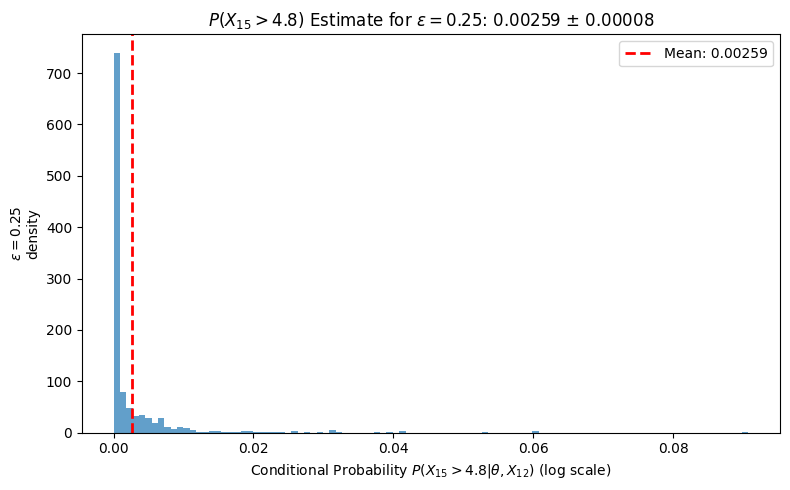

In [8]:
def analytical_prob_X15(theta, X12, c=4.8):
    """
    Computes P(X_15 > c | theta, X_12) using analytical Gaussian transition density

    Parameters:
    - theta: array-like w/ shape (4,) or (N, 4) containing [Ke, Ka, Cl, sigma]
    - X12: observed concentration at T=12
    - c: threshold value (default 4.8)

    Returns:
    - p: probability (or array of probabilities that X_15 > c)
    """

    # unpack parameters
    theta = np.asarray(theta)

    if theta.ndim == 1:
        Ke, Ka, Cl, sigma = theta
    else:
        Ke = theta[:, 0]
        Ka = theta[:, 1]
        Cl = theta[:, 2]
        sigma = theta[:, 3]
    
    # constants
    D = 4.0
    t_prev = 12.0
    t_next = 15.0
    dt = t_next - t_prev

    # calculate derived parameter alpha
    alpha = (D * Ka * Ke) / Cl

    # Deterministic Terms
    first_det_term = np.exp(-Ke * dt) * X12
    second_det_term = alpha/(Ke - Ka) * (np.exp(-Ka * t_next) - np.exp(-Ke * dt)*np.exp(-Ka * t_prev))
    
    # mean
    mu_15 = first_det_term + second_det_term

    # calculate conditional variance sigma—15^2
    var_15 = (sigma**2 / (2 * Ke)) * (1 - np.exp(-2 * Ke * dt))
    std_15 = np.sqrt(var_15)

    # compute tail probability
    z_score = (c - mu_15) / std_15

    # use survival function (1 - cdf), more numerically stable for tails
    p = norm.sf(z_score)

    return p

def goal6(theta_eps, data_obs, c=4.8, target_eps=0.25):
    """
    Computes and plots estimators for multiple epsilons
    """

    # get observed data
    X12 = data_obs[-1]

    print(data_obs)
    print(f"Observed X_12: {X12:.4f}")

    # define burn in
    burn_in = 2000

    # set up axes
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # get posterior samples (theta) for the target epsilon
    samples = theta_eps[target_eps]
    clean_samples = samples[burn_in:]

    # compute goal 6 estimator
    probabilities = analytical_prob_X15(clean_samples, X12, c)

    # get mean and std error
    estimate = np.mean(probabilities)
    error = np.std(probabilities) / np.sqrt(len(probabilities))

    # Calculate log-spaced bins for the histogram
    # We ensure probabilities are > 0 to avoid log10 errors
    valid_probs = probabilities[probabilities > 0]
    
    # plot histogram using the log-spaced bins
    ax.hist(probabilities, bins=100, alpha=0.7, density=True)
    
    # Set x-axis to log scale
    # ax.set_xscale('log')
    
    # add mean estimate line
    ax.axvline(estimate, color='red', linestyle='--', linewidth=2, label=f'Mean: {estimate:.5f}')
    ax.set_ylabel(rf"$\epsilon={target_eps}$" + "\n" + "density")
    ax.set_title(rf"$P(X_{{15}} > {c})$ Estimate for $\epsilon={target_eps}$: {estimate:.5f} $\pm$ {error:.5f}")
    ax.legend(loc='upper right')
    ax.set_xlabel(r'Conditional Probability $P(X_{15} > 4.8 | \theta, X_{12})$ (log scale)')
        
    plt.tight_layout()
    plt.show()

# run goal6
goal6(thetas_eps, data_obs)

print()
    